# Inference: Slice Sampling with Overrelaxation
This example shows you how to perform Bayesian inference on a Gaussian distribution and a time-series problem, using
[Slice Sampling with Stepout](./slice-stepout-mcmc.ipynb) and Overrelaxation.

Slice Sampling with Stepout is a univariate method, which is applied in a Slice-Sampling-within-Gibbs framework to allow MCMC sampling from multivariate models. It generates samples by sampling uniformly from the volume underneath the posterior ($f$). It does so by introducing an auxiliary variable ($y$) and by defining a Markov chain.

If the distribution is univariate, sampling follows:

1. Calculate the pdf ($f(x_0)$) of the current sample ($x_0$).
2. Draw a real value ($y$) uniformly from ($0, f(x_0)$), defining a horizontal “slice”: $S = {x: y < f (x)}$. Note that $x_0$ is always within $S$.
3. Find an interval ($I = (L, R)$) around $x_0$ that contains all, or much, of the slice.
4. Draw a new point ($x_1$) from the part of the slice within this interval.

If the distribution is multivariate, we apply the univariate algorithm to each variable in turn, where the other variables are set at their current values.

In this notebook, we use the Stepout procedure to estimate the interval $I$ : we expand the initial interval by a width in each direction until both edges fall outside the slice, or until a predetermined limit is reached.

Overrelaxed steps increase sampling efficiency in highly correlated
    unimodal distributions by suppressing the random walk behaviour of
    single-variable slice sampling: each variable is still updated in turn,
    but rather than drawing a new value for a variable from its conditional
    distribution independently of the current value, the new value is instead
    chosen to be on the opposite side of the mode from the current value. The
    interval $I$ is still calculated via Stepout, and the edges $(L,R)$ are
    used to estimate the slice endpoints via bisection. To obtain a full
    sampling scheme, overrelaxed updates are alternated with normal Stepout
    updates.

First, we create a normal distribution with correlated parameters.

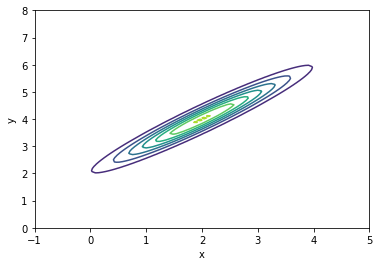

In [1]:
import pints
import pints.toy
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Create log pdf
log_pdf = pints.toy.GaussianLogPDF([2, 4], [[1, 0.96], [0.96, 1]])

# Contour plot of pdf
levels = np.linspace(-3,12,20)
num_points = 100
x = np.linspace(-1, 5, num_points)
y = np.linspace(-0, 8, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Set MCMCController and Overrelaxation Parameter

The probability of pursuing an overrelaxed step (0 as default) and the number of bisection iterations are hyperparameters. In [1], Neal suggests to set almost every update to being overrelaxed and to set a high number of interval expansion steps.

[1] Neal, R.M., 2003. Slice sampling. The annals of statistics, 31(3),
    pp.705-767.

In [2]:
# Choose starting point for 3 mcmc chains
xs = [
    [2, 4],
    [3, 3],
    [5, 4],
]

# Create mcmc routine
mcmc = pints.MCMCController(log_pdf, 3, xs, method=pints.SliceStepoutMCMC)

# Add stopping criterion
mcmc.set_max_iterations(2000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(500)

for sampler in mcmc.samplers():
    sampler.set_width([0.1, 0.1])
    sampler.set_expansion_steps(100)
    sampler.set_prob_overrelaxed(0.90)
    sampler.set_bisection_steps(10)

# Run!
print('Running...')
full_chains_overrelaxed = mcmc.run()
print('Done!')

Running...
Using Slice Sampling - Stepout
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.0
1     486     0:00.0
2     792     0:00.0
3     1089    0:00.0
500   89808   0:02.1
1000  178764   0:04.2
1500  266247   0:06.2
2000  353313   0:08.3
Halting: Maximum number of iterations (2000) reached.
Done!


We first use Pints' [trace](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.trace) tool to check the convergence of the chains.

In [3]:
# Check convergence and other properties of chains
results = pints.MCMCSummary(chains=full_chains_overrelaxed, time=mcmc.time(), parameter_names=['mean_x', 'mean_y'])
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
mean_x   2.01    0.96    0.10    1.36   2.01   2.65   3.85     1.00    992.56  120.03
mean_y   4.01    0.96    2.09    3.36   4.03   4.65   5.86     1.00    990.95  119.84


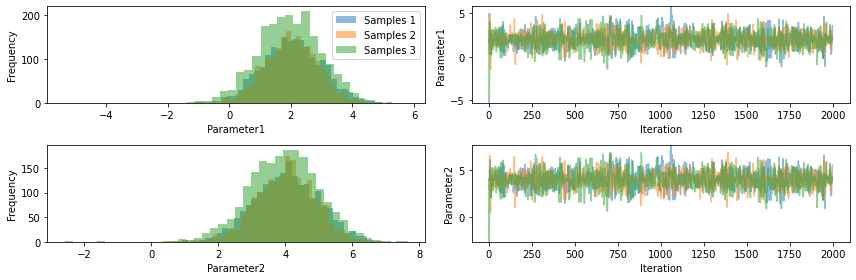

In [4]:
# Show traces and histograms
import pints.plot
pints.plot.trace(full_chains_overrelaxed)
plt.show()

From the plots, we can see that the chains rapidly converge after a few MCMC steps.

As our target distribution is Gaussian, we can calculate analytically the KL divergence between the distributions obtained from the chains and the true posterior distribution. We would expect the KL values to be be approximately $0$ to indicate no loss of information between the distributions.

In [5]:
# Check Kullback-Leibler divergence of chains
print(log_pdf.kl_divergence(full_chains_overrelaxed[0]))
print(log_pdf.kl_divergence(full_chains_overrelaxed[1]))
print(log_pdf.kl_divergence(full_chains_overrelaxed[2]))

0.00402360415083991
0.02004749116134885
0.00781746955384044


We can now look at the correlation between the different parameters by using the [pairwise()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.pairwise) plot.

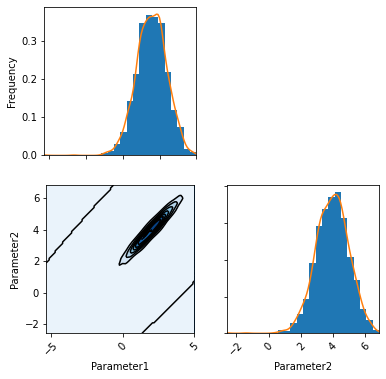

In [6]:
pints.plot.pairwise(full_chains_overrelaxed[2], kde=True)
plt.show()

We now create a new function to plot the average KL divergence among the different chains against the number of MCMC steps.

In [7]:
import matplotlib.pyplot as plt

def plot_kl(chains, name):
    kl = []
    for i in range(100):
        temp = []
        for s, chain in enumerate(chains):
            temp.append(log_pdf.kl_divergence(chain[:i]))
        kl.append(np.sum(temp)/len(chains))
    
    plt.plot(kl)
    plt.title(name)
    plt.ylim(0, 10)
    plt.ylabel('KL Divergence')
    plt.xlabel('Iteration')
    plt.show()

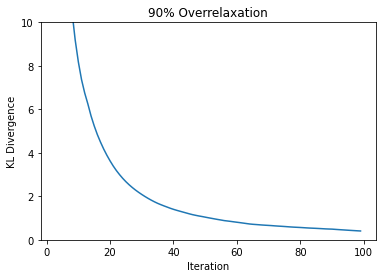

In [8]:
plot_kl(full_chains_overrelaxed, "90% Overrelaxation")

From the plot, we can see that the KL divergence rapidly approaches $0$ after approximately 60 MCMC steps, indicating that the distribution obtained using the samples rapidly converges to the target distribution.

We compare the KL plot for the overrelaxed run against a normal Slice Sampling with Stepout run.

In [9]:
# Create mcmc routine
mcmc = pints.MCMCController(log_pdf, 3, xs, method=pints.SliceStepoutMCMC)

# Add stopping criterion
mcmc.set_max_iterations(2000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(1000)

for sampler in mcmc.samplers():
    sampler.set_width([0.1, 0.1])
    sampler.set_expansion_steps(100)
    sampler.set_prob_overrelaxed(0)
    
# Run!
print('Running...')
full_chains_stepout = mcmc.run()
print('Done!')

Running...
Using Slice Sampling - Stepout
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.0
1     261     0:00.0
2     489     0:00.0
3     708     0:00.0
1000  70506   0:01.6
2000  140274   0:03.3
Halting: Maximum number of iterations (2000) reached.
Done!


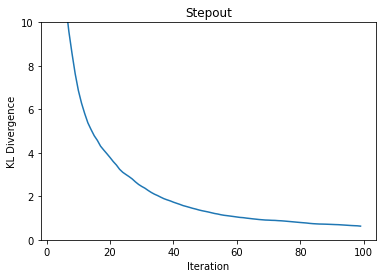

In [10]:
plot_kl(full_chains_stepout, "Stepout")

Despite being slightly better, the plot for the overrelaxed run is very similar to the one of the normal Slice Sampling with Stepout run, showing only a marginal improvement in the speed of approaching $0$.

# Overrelaxation on High-Dimensional Distributions

We now test Slice Sampling with Overrelaxation on a high-dimensional Gaussian distribution with 10 dimensions.

In [11]:
# Create log pdf
log_pdf = pints.toy.HighDimensionalGaussianLogPDF(dimension=10)

# Create an adaptive covariance MCMC routine
x0 = np.random.uniform(-10, -5, size=(3, 10))
mcmc = pints.MCMCController(log_pdf, 3, x0, method=pints.SliceStepoutMCMC)
for sampler in mcmc.samplers():
    sampler.set_width(1)
    sampler.set_expansion_steps(50)
    sampler.set_bisection_steps(10)
    sampler.set_prob_overrelaxed(0.90)
    
# Stop after 100 iterations
mcmc.set_max_iterations(100)
mcmc.set_log_interval(50)

# Run!
print('Running...')
full_chains_HD_overrelaxation = mcmc.run()
print('Done!')

Running...
Using Slice Sampling - Stepout
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.0
1     1170    0:00.0
2     2112    0:00.1
3     3060    0:00.1
50    41400   0:01.0
100   79975   0:01.9
Halting: Maximum number of iterations (100) reached.
Done!


In [12]:
mcmc = pints.MCMCController(log_pdf, 3, x0, method=pints.SliceStepoutMCMC)
for sampler in mcmc.samplers():
    sampler.set_width(1)
    sampler.set_expansion_steps(50)
    sampler.set_bisection_steps(0)
    sampler.set_prob_overrelaxed(0)

# Stop after 100 iterations
mcmc.set_max_iterations(100)
mcmc.set_log_interval(50)

# Run!
print('Running...')
full_chains_HD_stepout = mcmc.run()
print('Done!')

Running...
Using Slice Sampling - Stepout
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.0
1     672     0:00.0
2     1116    0:00.0
3     1458    0:00.0
50    13887   0:00.3
100   25633   0:00.6
Halting: Maximum number of iterations (100) reached.
Done!


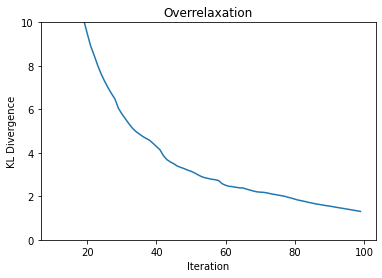

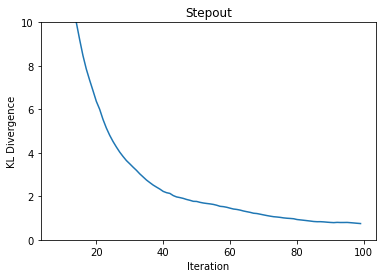

In [13]:
plot_kl(full_chains_HD_overrelaxation, "Overrelaxation")
plot_kl(full_chains_HD_stepout, "Stepout")

Interestingly, for higher dimensions, the Overrelaxation run approaches 0 more slowly compared to a normal Slice Sampling with Stepout run. This indicates that the probability of pursuing an overrelaxed run is an important hyperparameter which requires appropriate tuning.